# **IMPORTATIONS**

In [170]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [171]:
import pickle
with open('df_complete.pickle', 'rb') as f:
    df = pickle.load(f)

# **PRE-PROCESSING**

On normalise les données et sépare les données d'entrainement et de tests : 

In [172]:
X, y = df.drop(columns=['num']).values, df['num'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **MODÈLE**

Regardons dans un premier temps les paramètre qu'utilise le KNeighborsClassifier par défault : 

In [173]:
classifier = KNeighborsClassifier()
print('Paramètres utilisés : \n')
pprint(classifier.get_params())

Paramètres utilisés : 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


On joue sur ces paramètres et notamment sur le nombre de voisins pour déterminer quels sont les meilleurs paramètres (en utilisant GridSearchCV) : 

In [174]:
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
param_grid = {'n_neighbors': n_neighbors}
knn = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knn, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    5.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [175]:
print("Les meilleurs paramètres (d'après la GridSearch) sont :")
print(grid_search.best_params_)
print("")
print("La précision moyenne d'un modèle avec ces hyperparamètres est:")
print(grid_search.best_score_)

Les meilleurs paramètres (d'après la GridSearch) sont :
{'n_neighbors': 27}

La précision moyenne d'un modèle avec ces hyperparamètres est:
0.813443072702332


On prend alors le modèle avec les meilleurs paramètres : 

In [176]:
best_knn = grid_search.best_estimator_

In [177]:
best_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=27, p=2,
                     weights='uniform')

In [178]:
knn_pred = best_knn.predict(X_test)

**Regardons les résultats pour les données d'entrainement :**

* matrice de confusion :

Text(0.5, 1, 'Confusion Matrix')

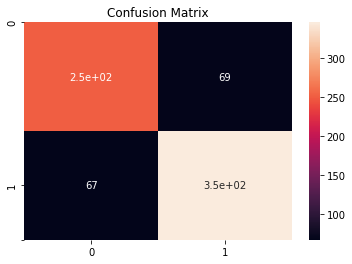

In [179]:
cm = confusion_matrix(y_train, best_knn.predict(X_train))

df_cm = pd.DataFrame(cm, index=['1','0'], columns = ['0','1'])
fig = plt.figure()
plt.clf()

res = sns.heatmap(df_cm, annot=True)

plt.yticks( [1.5,0,2], va='center')
plt.title('Confusion Matrix')

* accuracy : 

In [180]:
print("Accuracy pour les données d'entrainement est : ")
print(accuracy_score(y_train, best_knn.predict(X_train)))

Accuracy pour les données d'entrainement est : 
0.8147138964577657


* sensibilité : 

In [181]:
tpr = recall_score(y_train, best_knn.predict(X_train))
print("La sensibilité pour les données d'entrainement est : ")
print(tpr)

La sensibilité pour les données d'entrainement est : 
0.837772397094431


* précision : 

In [182]:
print("La précision pour les données d'entrainement est : ")
print(precision_score(y_train, best_knn.predict(X_train)))

La précision pour les données d'entrainement est : 
0.8337349397590361


* F-Measure :

In [183]:
print("F-Measure pour les données d'entrainement : ")
print(f1_score(y_train, best_knn.predict(X_train)))

F-Measure pour les données d'entrainement : 
0.8357487922705313


**Résultats pour les données tests :**

* matrice de confusion : 

Text(0.5, 1, 'Confusion Matrix')

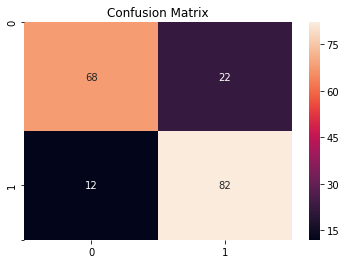

In [184]:
cm = confusion_matrix(y_test, knn_pred)

df_cm = pd.DataFrame(cm, index=['1','0'], columns = ['0','1'])
fig = plt.figure()
plt.clf()

res = sns.heatmap(df_cm, annot=True)

plt.yticks( [1.5,0,2], va='center')
plt.title('Confusion Matrix')

* accuracy : 

In [185]:
print("Accuracy pour les données test : ")
print(accuracy_score(y_test, knn_pred))

Accuracy pour les données test : 
0.8152173913043478


* sensibilité : 

In [186]:
tpr = recall_score(y_test, knn_pred)
print("La sensibilité pour les données tests est : ")
print(tpr)

La sensibilité pour les données tests est : 
0.8723404255319149


* précision : 

In [187]:
print("La précision pour les données test est : ")
print(precision_score(y_test, knn_pred))

La précision pour les données test est : 
0.7884615384615384


* F-Measure : 

In [188]:
print("F-Measure pour les données test : ")
print(f1_score(y_test, knn_pred))

F-Measure pour les données test : 
0.8282828282828283


**Regroupons tout ça dans un dataframe pandas :**

In [189]:
d = {
     'Model': 'KNN',
     'Training Set Accuracy': accuracy_score(y_train, best_knn.predict(X_train)),
     'Test Set Accuracy': accuracy_score(y_test, knn_pred),
     'Training Set TPR' : recall_score(y_train, best_knn.predict(X_train)),
     'Test Set TPR' : recall_score(y_test, knn_pred),
     'Training Set PPV' : precision_score(y_train, best_knn.predict(X_train)),
     'Test Set PPV' : precision_score(y_test, knn_pred),
     'Training Set F-Measure' : f1_score(y_train, best_knn.predict(X_train)),
     'Test Set F-Measure' : f1_score(y_test, knn_pred)
}

df_models_knn = pd.DataFrame(d, index=[0])
df_models_knn

,Model,Training Set Accuracy,Test Set Accuracy,Training Set TPR,Test Set TPR,Training Set PPV,Test Set PPV,Training Set F-Measure,Test Set F-Measure
0,KNN,0.814714,0.815217,0.837772,0.87234,0.833735,0.788462,0.835749,0.828283


In [190]:
with open('df_models_knn.pickle', 'wb') as output:
    pickle.dump(df_models_knn, output)